FREQUENCY                      0
ANGLE_OF_ATTACK                0
CHORD_LEN                      0
FREE_STREAM_VELOCITY           0
SUCTION_SIDE_DISP_THICKNESS    0
SCALED_SOUND_PRESSURE          0
dtype: int64
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   FREQUENCY                    1503 non-null   int64  
 1   ANGLE_OF_ATTACK              1503 non-null   float64
 2   CHORD_LEN                    1503 non-null   float64
 3   FREE_STREAM_VELOCITY         1503 non-null   float64
 4   SUCTION_SIDE_DISP_THICKNESS  1503 non-null   float64
 5   SCALED_SOUND_PRESSURE        1503 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 70.6 KB
                             FREQUENCY  ANGLE_OF_ATTACK  CHORD_LEN  \
FREQUENCY                     1.000000        -0.272765  -0.003661   
ANGLE_OF_ATTACK           

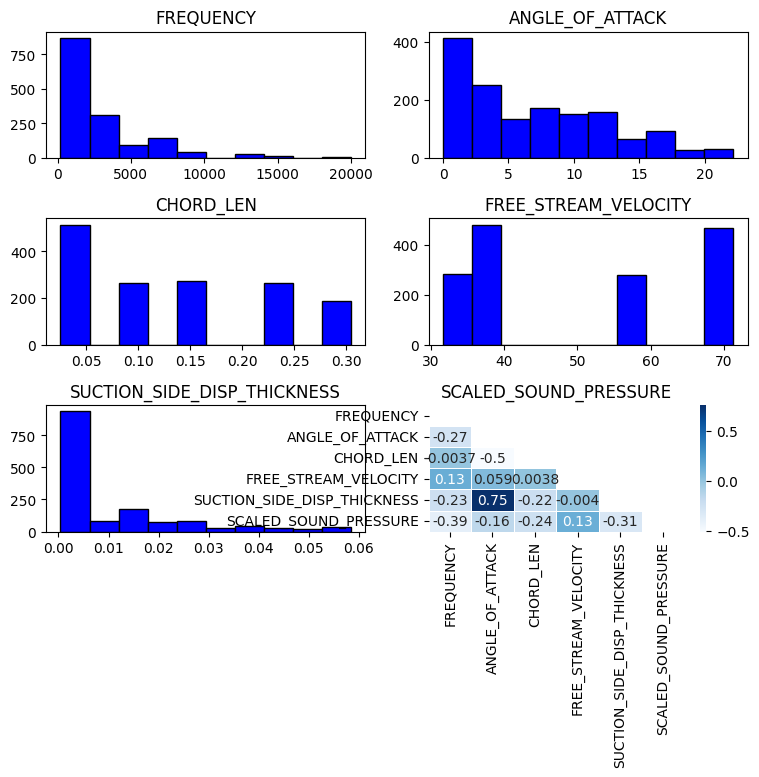

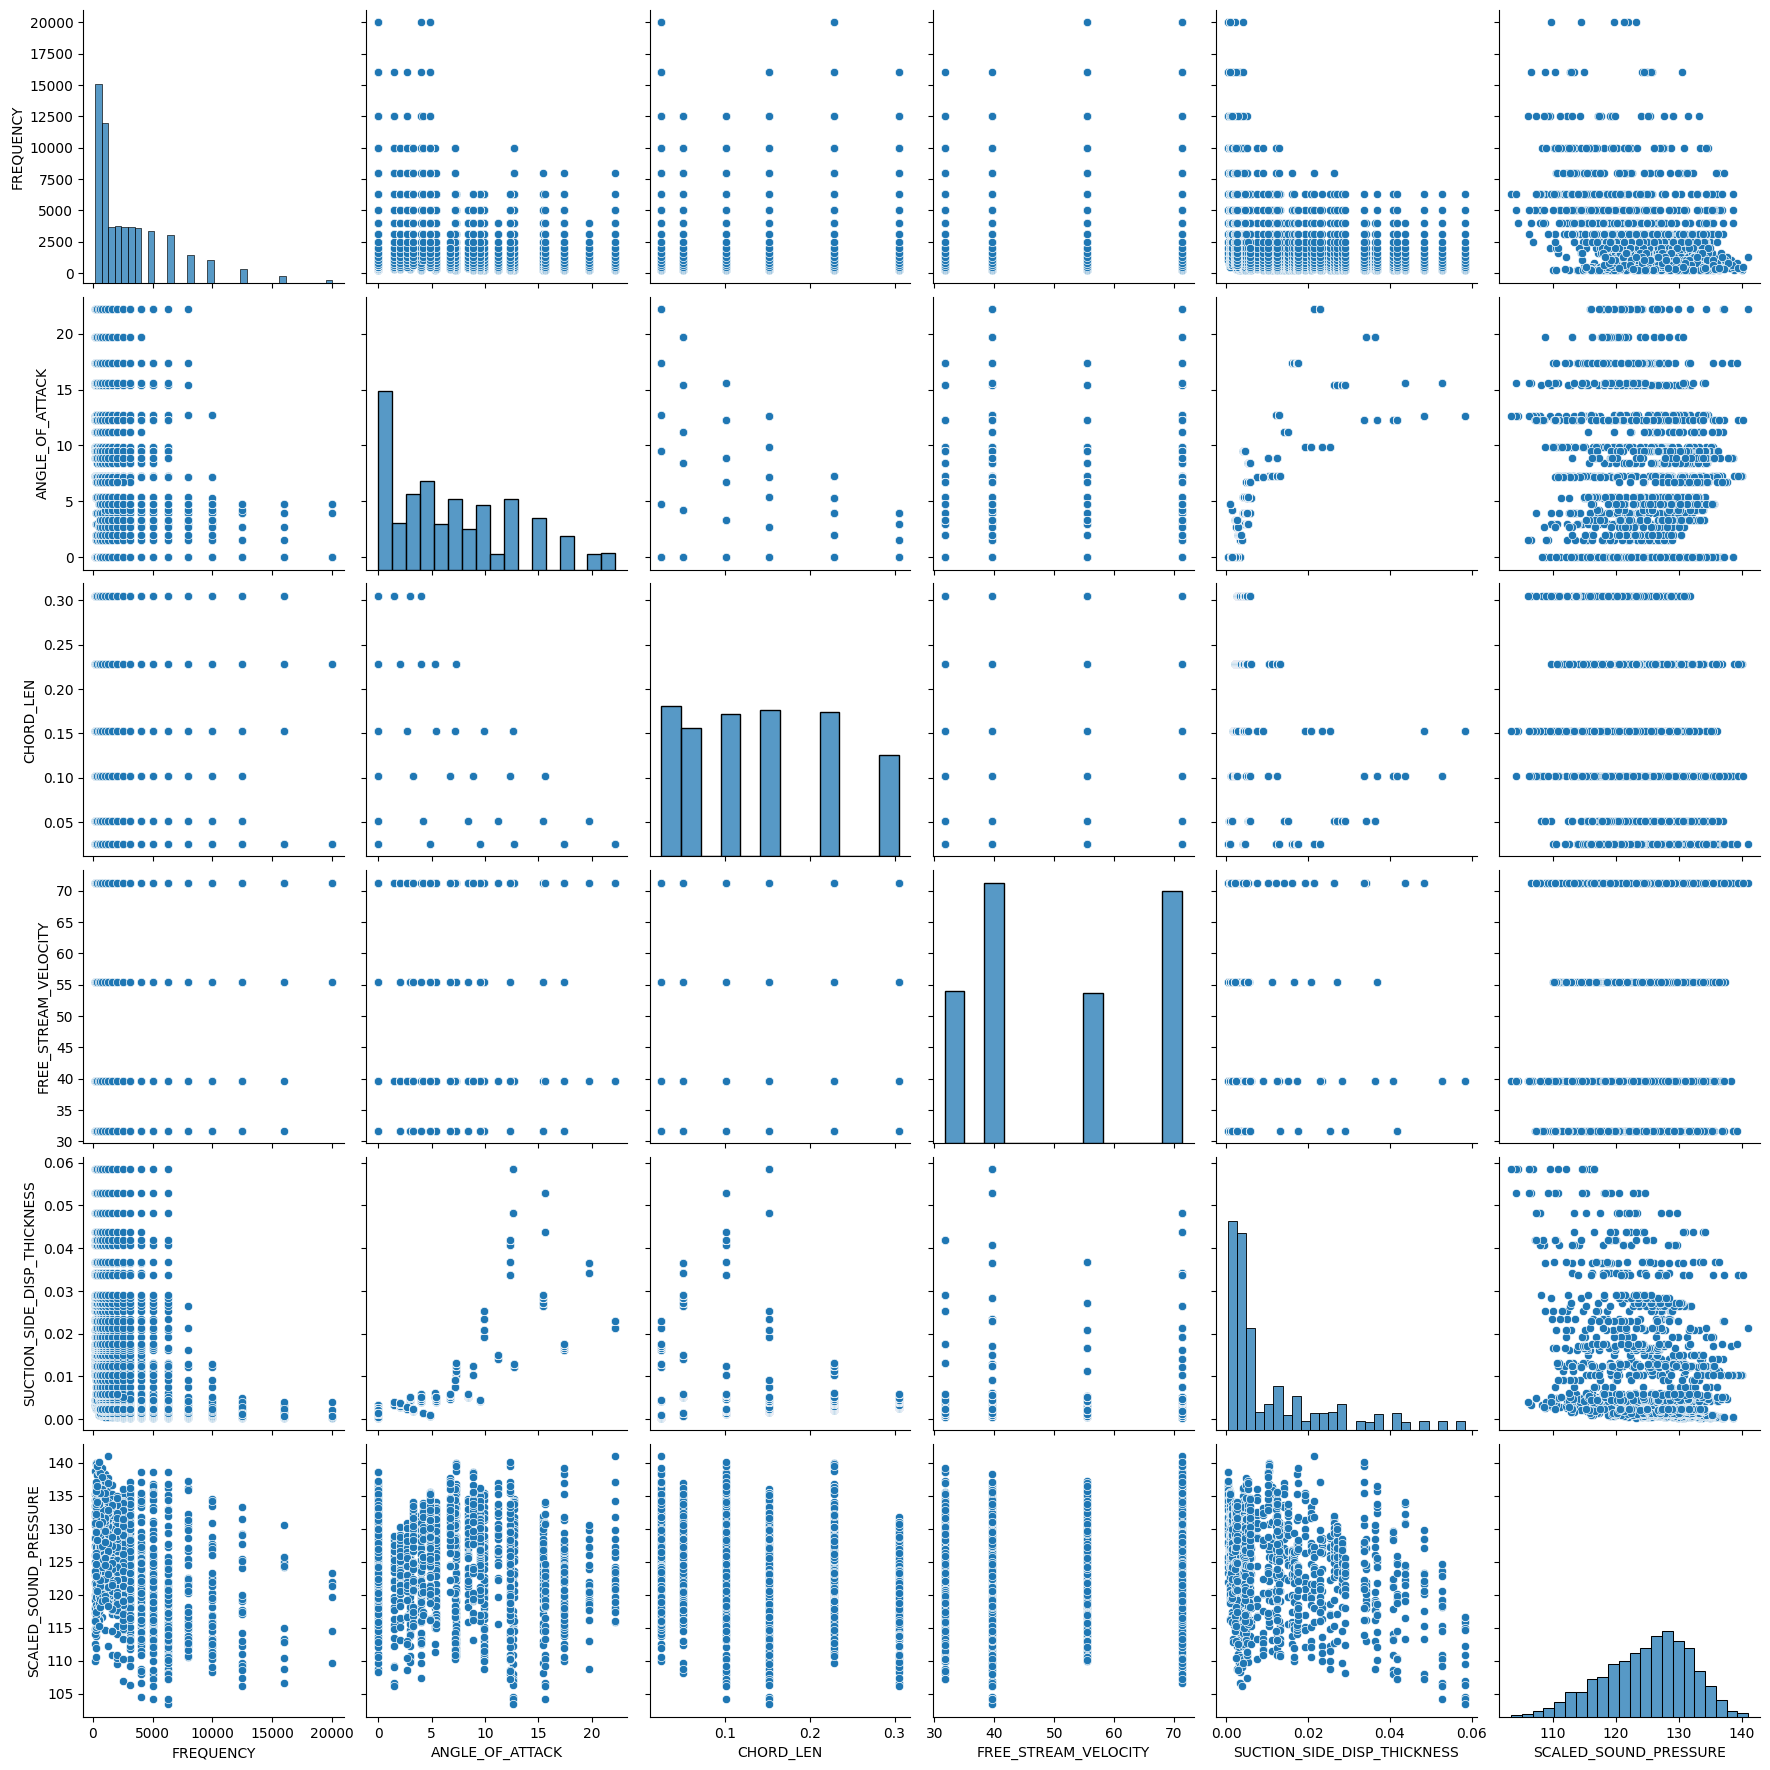

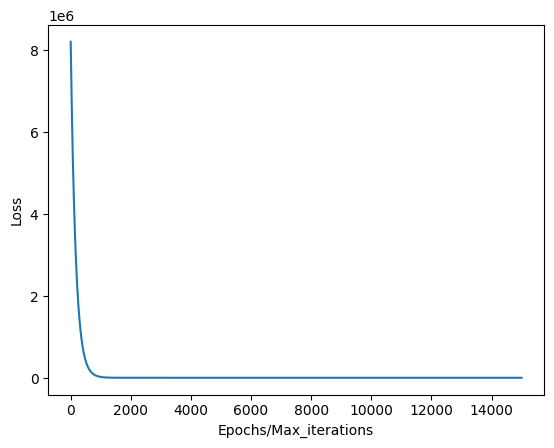

Training Error for Learning Rate: 0.003, Iterations= 15000
R2 Score:  0.5413436504736235
Mean absolute error:  3.650018566789394
Root Mean squared error:  4.702274467351157
Explained Variance Score:  0.5413436504713265
Test Error for Learning Rate: 0.003, Iterations= 15000
R2 Score:  0.4394340449869476
Mean absolute error:  3.8465593830647173
Root Mean squared error:  5.080314923808187
Explained Variance Score:  0.4398882474500636
Training Error for Learning Rate: 0.001, Iterations= 7000
R2 Score:  0.5398310148881753
Mean absolute error:  3.658227096172222
Root Mean squared error:  4.710027155966432
Explained Variance Score:  0.5400941790634592
Wrote to file sucessfully.
Training Error for Learning Rate: 0.001, Iterations= 10000
R2 Score:  0.5410015983207128
Mean absolute error:  3.6523954192603263
Root Mean squared error:  4.704028157032606
Explained Variance Score:  0.54100213622922
Wrote to file sucessfully.
Training Error for Learning Rate: 0.001, Iterations= 15000
R2 Score:  0.541

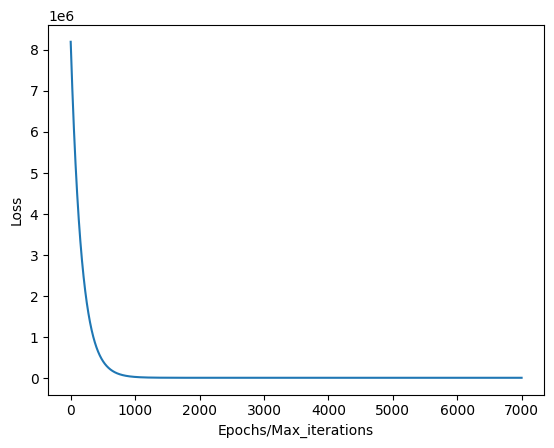

Training Error for Learning Rate: 0.003, Iterations= 7000
R2 Score:  0.5413313525764742
Mean absolute error:  3.6499352612859064
Root Mean squared error:  4.70233757244717
Explained Variance Score:  0.5413313399405877
Test Error for Learning Rate: 0.003, Iterations= 7000
R2 Score:  0.43817902643156914
Mean absolute error:  3.8515351875242416
Root Mean squared error:  5.085998755279436
Explained Variance Score:  0.43863875260417184


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression, SGDRegressor

import warnings
warnings.filterwarnings('ignore')

## Loading the dataset.
#Read csv file data into a dataframe and peek top 5 rows.
cols = ['FREQUENCY', 'ANGLE_OF_ATTACK', 'CHORD_LEN', 'FREE_STREAM_VELOCITY', 'SUCTION_SIDE_DISP_THICKNESS',
        'SCALED_SOUND_PRESSURE']
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat', sep='\t', names=cols)
df.head()

## Pre-processing Step

#detect and remove fields with duplicated, None, NaN, or empty '' values.
pd.options.mode.use_inf_as_na = True
print(df.isnull().sum())
print(df.duplicated().sum())

df.dropna(inplace=True)
df.drop_duplicates()

## Exploratory Data Analysis

#information about the attributes.
df.info()

#exploring the dataset
df.describe()

#exploring the target variable
df['SCALED_SOUND_PRESSURE'].describe()

## Feature Engineering
###Histogram
df.hist(color='blue', edgecolor='black', grid=False)
plt.tight_layout(rect=(0,0,1.2,1.2))

#computing pairwise correlations in the dataset
corrs = df.corr()
print(corrs)

#Correlations consist of redundancies. Removing using a boolean mask:
mask = np.triu(np.ones_like(corrs, dtype=bool))

### Heatmap
#plot heatmap to visualize the magnitude of correlation between each pair
seaborn.heatmap(corrs, mask=mask, cmap="Blues", annot=True, linewidth=0.5)
plt.show()

### Pairplot
#checking pair-wise correlationships in the dataset.

seaborn.pairplot(df, height=3)
plt.show()

## Part-1: Implementing an SGD Regressor Without Libraries

### Splitting data into dependent and independent variables - x&y

x = df.iloc[:,:-1]
y = df.iloc[:,-1]

#Splitting data into 70/30 train/test samples
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=True)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

#Resizing the distribution of values so that the mean of the observed values is 0 and the standard deviation is 1
sc = StandardScaler()

x_train_trans = sc.fit_transform(x_train)
x_test_trans = sc.transform(x_test)

class ManualSGD:
    def __init__(self, learning_rate=0.001, epochs=500, threshold=None):
        self.learning_rate=learning_rate
        self.epochs=epochs
        self.threshold=threshold

    #predicting values using our model
    def predict(self, x_test_trans):
        x = np.insert(x_test_trans.T,0,np.ones(x_test_trans.shape[0]),axis=0)
        dot_prod = np.dot(self.weights, x)
        return dot_prod

    def Rsquared(self,x,y):
        return 1-(((y - self.predict(x))**2).sum()/((y - y.mean())**2).sum())

    def loss_function(self,x,y,category='mse'):
        if category == 'mse':
            loss=np.sum(np.square(x.reshape(-1, 1) - y.reshape(-1, 1)))/(2*x.shape[0])
        return np.round(loss,3)

    def fit(self,x,y):
        self.losses=[] #list to track the losses
        self.x=x
        self.y=y
        self.weights = np.random.rand(self.x.shape[1]+1).reshape(1,-1)
        self.feature_vector = np.insert(self.x.T, 0,np.ones(self.x.shape[0]), axis=0)
        dw=0

        while self.epochs>=0:
            self.hyp = np.dot(self.weights,self.feature_vector)
            self.losses.append(self.loss_function(self.hyp,y))
            # @ is matrix multiplication
            dw = (self.feature_vector@(self.hyp-self.y).T)
            dw /= self.x.shape[0]        #average it
            self.weights -= (self.learning_rate*dw.reshape(1,-1))
            #update weights
            self.epochs -= 1 #decrement iterations count by 1

#Optimum Learning Rate and Iterations
lr, itrs = 0.003, 15000

#create object of class
model = ManualSGD(learning_rate=lr,epochs=itrs)

#fit the training data on the model
model.fit(x_train_trans,np.array(y_train))

#predict
y_pred=model.predict(x_test_trans)

loss=list(model.losses)
#visualize loss
plt.plot(loss)
plt.xlabel("Epochs/Max_iterations")
plt.ylabel("Loss")
plt.show()

r2 = model.Rsquared(x_train_trans,np.array(y_train))
mae = mean_absolute_error(y_train, model.hyp[0])
rmse = mean_squared_error(y_train, model.hyp[0], squared=False)
evs = explained_variance_score(y_train, model.hyp[0])

print("Training Error for Learning Rate: "+str(lr)+", Iterations= "+str(itrs))
print("======================================")
print("R2 Score: ", r2)
print("Mean absolute error: ", mae)
print("Root Mean squared error: ", rmse)
print("Explained Variance Score: ", evs)

r2 = model.Rsquared(x_test_trans,np.array(y_test))
mae = mean_absolute_error(y_test, y_pred[0])
rmse = mean_squared_error(y_test, y_pred[0], squared=False)
evs = explained_variance_score(y_test, y_pred[0])

print("Test Error for Learning Rate: "+str(lr)+", Iterations= "+str(itrs))
print("======================================")
print("R2 Score: ", r2)
print("Mean absolute error: ", mae)
print("Root Mean squared error: ", rmse)
print("Explained Variance Score: ", evs)

lr_list = [0.001, 0.003, 0.01, 0.1, 0.25]
epoch_list = [7000, 10000, 15000, 25000, 40000]

for lr in lr_list:
  for itrs in epoch_list:
    model = ManualSGD(learning_rate=lr,epochs=itrs)
    model.fit(x_train_trans,np.array(y_train))

    r2 = model.Rsquared(x_train_trans,np.array(y_train))
    mae = mean_absolute_error(y_train, model.hyp[0])
    rmse = mean_squared_error(y_train, model.hyp[0], squared=False)
    evs = explained_variance_score(y_train, model.hyp[0])

    print("Training Error for Learning Rate: "+str(lr)+", Iterations= "+str(itrs))
    print("======================================")
    print("R2 Score: ", r2)
    print("Mean absolute error: ", mae)
    print("Root Mean squared error: ", rmse)
    print("Explained Variance Score: ", evs)

    file = open("Manual_SGD_log.txt","a")
    file.write("LR = " + str(lr) + ", max_iterations = " + str(itrs) +
              ", R^2 = "+str(r2) + ", MAE = "+str(mae) + ", RMSE = " + str(rmse) +
              ", Explained-Variance = " + str(evs) + " \n")
    file.close()

    print("Wrote to file sucessfully.")

"""# **From the above set of experiments, the best performance was exhibited by the combination of learning rate=0.003 and epochs=7,000.** """

#Optimum Learning Rate and Iterations
lr, itrs = 0.003, 7000

#create object of class
model = ManualSGD(learning_rate=lr,epochs=itrs)

#fit the training data on the model
model.fit(x_train_trans,np.array(y_train))

#predict
y_pred=model.predict(x_test_trans)

loss=list(model.losses)
#visualize loss
plt.plot(loss)
plt.xlabel("Epochs/Max_iterations")
plt.ylabel("Loss")
plt.show()

r2 = model.Rsquared(x_train_trans,np.array(y_train))
mae = mean_absolute_error(y_train, model.hyp[0])
rmse = mean_squared_error(y_train, model.hyp[0], squared=False)
evs = explained_variance_score(y_train, model.hyp[0])

print("Training Error for Learning Rate: "+str(lr)+", Iterations= "+str(itrs))
print("======================================")
print("R2 Score: ", r2)
print("Mean absolute error: ", mae)
print("Root Mean squared error: ", rmse)
print("Explained Variance Score: ", evs)

r2 = model.Rsquared(x_test_trans,np.array(y_test))
mae = mean_absolute_error(y_test, y_pred[0])
rmse = mean_squared_error(y_test, y_pred[0], squared=False)
evs = explained_variance_score(y_test, y_pred[0])

print("Test Error for Learning Rate: "+str(lr)+", Iterations= "+str(itrs))
print("======================================")
print("R2 Score: ", r2)
print("Mean absolute error: ", mae)
print("Root Mean squared error: ", rmse)
print("Explained Variance Score: ", evs)